In [1]:
# set seed for reproducibility
set.seed(1729)

Packages required for this post:

In [2]:
library(rbenchmark) # for benchmarking
library(readr) # for reading CSVs

## The Issue With Zero Variance Columns

### Introduction

Whenever you have a column in a data frame with only one distinct value, that column will have zero variance. In fact the reverse is true too; a zero variance column will always have exactly one distinct value. The proof of the former statement follows directly from the definition of variance. The proof of the reverse, however, requires some basic knowledge of  measure theory - specifically that if the expectation of a non-negative random variable is zero then the random variable is equal to zero.

The existance of zero variance columns in a data frame may seem benign and in most cases that is true. There are however several algorithms that will be halted by their presence. An example of such is the use of principle component analysis (or PCA for short). If you are unfamiliar with this technique, I suggest reading through [this article](https://www.analyticsvidhya.com/blog/2016/03/practical-guide-principal-component-analysis-python/) by the Analytics Vidhya Content Team which includes a clear explanation of the concept as well as how it can be implemented in R and Python.

### The MNIST data set

Let's suppose that we wish to perform PCA on the [MNIST](http://yann.lecun.com/exdb/mnist/) Handwritten Digit data set. We shall begin by importing a reduced version of the data set from a CSV file and having a quick look at its structure.

In [6]:
# import data set
mnist <- read_csv("mnist_reduced.csv", 
                  col_names = c("Label", paste0("P", 1:28^2)),
                  col_types = cols(.default = "i"))

# get the dimensions of the data
dim(mnist)

[1] 1000  785

In [7]:
# look at a sample of the predictors
head(mnist[, c(1, sample(1:785, 10))])

Label,P333,P419,P185,P752,P18,P668,P510,P361,P218,P41
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
5,0,0,253,0,0,0,0,0,56,0
0,0,0,252,0,0,0,0,0,122,0
4,0,0,0,0,0,0,0,0,210,0
1,0,0,0,0,0,0,0,0,62,0
9,0,0,0,0,0,0,0,0,0,0
2,0,0,252,0,0,0,3,0,0,0


As we can see, the data set is made up of 1000 observations each of which contains 784 pixel values each from 0 to 255. These come from a 28x28 grid representing a drawing of a numerical digit. The label for the digit is given in the first column. We can visualise what the data represents as such.

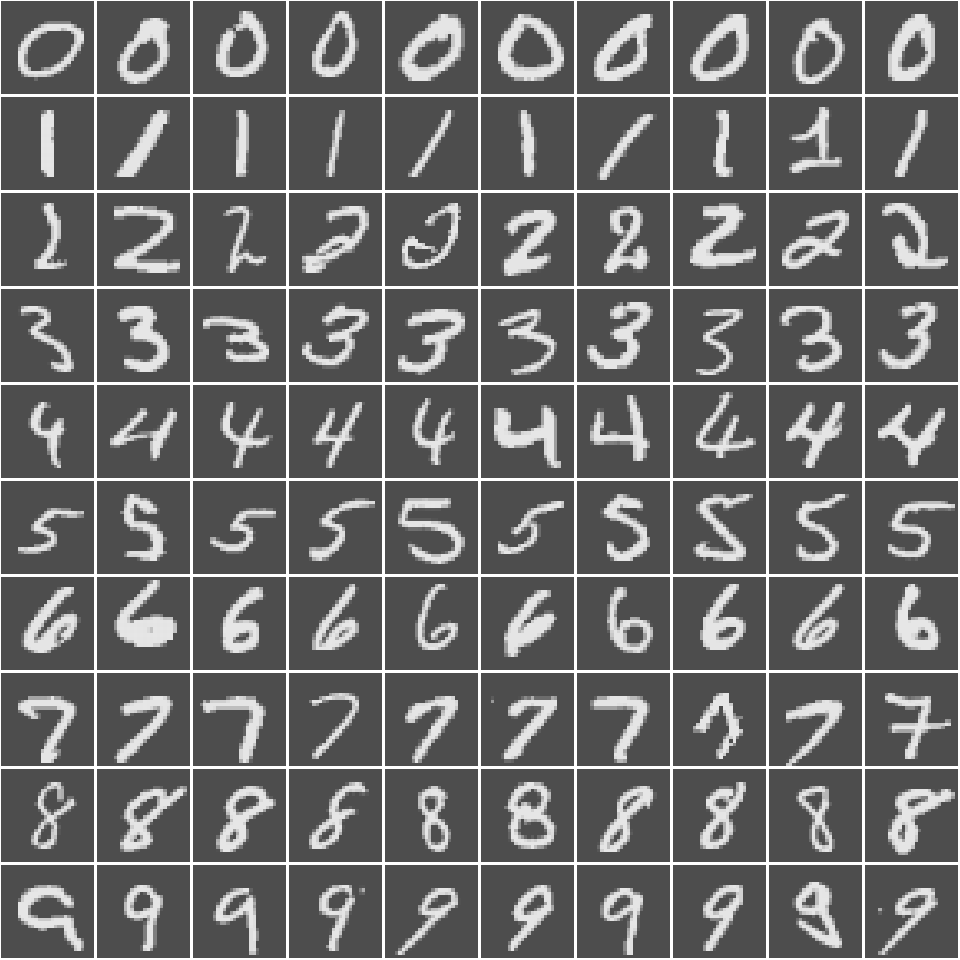

In [11]:
options(repr.plot.width=8, 
        repr.plot.height=8,
        jupyter.plot_mimetypes = "image/png")

# choose 10 digits for each label
samp <- sapply(0:9, function(x) sample(which(mnist$Label == x), 10))
# form into a matrix
pxlVals <- t(mnist[samp, -1])
pxlVals.mtrx <- lapply(1:100, function(x) matrix(pxlVals[,x], ncol = 28))
par(mfrow = c(10,10), mar = rep(.1, 4))
                       
for(i in 1:100){
    for(j in 1:28) {
    # restructure to use same coordinate system as image()
    pxlVals.mtrx[[i]][j,] <- rev(pxlVals.mtrx[[i]][j,])
  }
    image(pxlVals.mtrx[[i]],col=grey.colors(225),axes=F)
}

The code used to produce Figure 1 is beyond the scope of this blog post. However, the full code used to produce this document can be found on my [Github](https://github.com/THargreaves).

### An attempt at PCA

Now that we have an understanding of what our data looks like, we can have a go at applying PCA to it. Luckily for us, base R comes with a built-in function for implementing PCA.

If we run this, however, we will be faced with the following error message.

In [13]:
# blog post will not compile if an actual error occurs so we have to sythesise one
message("Error in prcomp.default(mnist[, -1], scale. = TRUE):\n  cannot rescale a constant/zero column to unit variance")

Error in prcomp.default(mnist[, -1], scale. = TRUE):
  cannot rescale a constant/zero column to unit variance


The issue is clearly stated: we can't run PCA (or least with scaling) whilst our data set still has zero variance columns. We must remove them first. It would be reasonable to ask why we don't just run PCA without first scaling the data first. In this scenario you may in fact be able to get away with it as all of the predictors are on the same scale (0-255) although even in this case, rescaling may help overcome the biased weighting towards pixels in the centre of the grid. 

The importance of scaling becomes even more clear when we consider a different data set. For example, one where we are trying to predict the monetary value of a car by it's MPG and mileage. These predictors are going to be on vastly different scales; the former is almost certainly going to be in the double digits whereas the latter will most likely be 5 or more digits. If we were to preform PCA without scaling, the MPG will completely dominate the results as a unit increase in its value is going to explain far more variance than the same increase in the mileage. Removing scaling is clearly not a workable option in all cases.

We are left with the only option of removing these troublesome columns.

# Removing Zero Variance Columns

### Methods for removing zero variance columns

Note that for the first and last of these methods, we assume that the data frame does not contain any `NA` values. This can easily be resolved, if that is the case, by adding `na.rm = TRUE` to the instances of the `var()`, `min()`, and `max()` functions. This will slightly reduce their efficiency. 

#### Method 1

We can now look at various methods for removing zero variance columns using R. The first off which is the most simple, doing exactly what it says on the tin.

In [14]:
removeZeroVar1 <- function(df){
  df[, sapply(df, var) != 0]
}

This simply finds which columns of the data frame have a variance of zero and then selects all columns but those to return. The issue with this function is that calculating the variance of many columns is rather computational expensive and so on large data sets this may take a long time to run (see benchmarking section for an exact comparison of efficiency). 

#### Method 2

We can speed up this process by using the fact that any zero variance column will only contain a single distinct value. This leads us to our second method.

In [15]:
removeZeroVar2 <- function(df){
  df[, sapply(df, function(x) length(unique(x)) > 1)]
}

This function finds which columns have more than one distinct value and returns a data frame containing only them. Further advantages of this method are that it can run on non-numeric data types such as characters and handle `NA` values without any tweaks needed.

#### Method 3

We can further improve on this method by, again, noting that a column has zero variance if and only if it is constant and hence its minimum and maximum values will be the same. This gives rise to our third method.

In [16]:
removeZeroVar3 <- function(df){
  df[, !sapply(df, function(x) min(x) == max(x))]
}

### Comparing the efficency of our methods

We now have three different solutions to our zero-variance-removal problem so we need a way of deciding which is the most efficient for use on large data sets. We can do this using [benchmarking](https://en.wikipedia.org/wiki/Benchmark_(computing)) which we can implement using the `rbenchmark` package. 

There are many other packages that can be used for benchmarking. The most popular of which is most likely Manuel Euguster's [benchmark](https://www.rdocumentation.org/packages/benchmark/versions/0.3-6) and another common choice is Lars Otto's [Benchmarking](https://www.rdocumentation.org/packages/Benchmarking/versions/0.27). [rbenchmark](https://www.rdocumentation.org/packages/rbenchmark/versions/1.0.0) is produced by Wacek Kusnierczyk and stands out in its simplicity - it is composed of a single function which is essentially just a wrapper for `system.time()`. It is more obscure than the other two packages mentioned but it's elegance makes it my favourite. 

Benchmarking with this package is performed using the `benchmark()` function. This accepts a series of unevaluated expressions as either named or unnamed arguments. It will then produce a data frame giving information about the efficiency of each of the captured expression, the columns of which can be choosen from a comprehensive set of options. The ordering of the rows in the resultant data frame can also be controlled, as well as the number of replications to be used for the test. For more information about this function, see the documentation linked above or use `?benchmark` after installing the package from CRAN.

We use the benchmarking function as follows.

In [20]:
benchmark(
  'Variance Method' = removeZeroVar1(mnist),
  'Unique Values Method' = removeZeroVar2(mnist),
  'Min-Max Method' = removeZeroVar3(mnist),
  columns = c("test", "replications", "elapsed", "relative"), 
  order = "elapsed",
  replications = 100
)

,test,replications,elapsed,relative
,<fct>,<int>,<dbl>,<dbl>
3,Min-Max Method,100,0.14,1.000
1,Variance Method,100,0.75,5.357
2,Unique Values Method,100,1.00,7.143


As we can see from the resulting table, the best method by far was the min-max method with the unique values and variance method being around 5 and 7 times slower respectively. When we next recieve an unexpected error message critiquing our data frames inclusion of zero variance columns, we'll now know what do!